In [46]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib


2022-05-31 15:52:17.114833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-31 15:52:17.114858: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
#Load images dir

data_dir = pathlib.Path("../datasets/teste1/")
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)
A = list(data_dir.glob('A/*'))
B = list(data_dir.glob('B/*'))

30


In [5]:
#Define some default variables

batch_size = 10 #total of 2
img_height = 32
img_width = 32

In [6]:
#Create training dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.34,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 30 files belonging to 2 classes.
Using 20 files for training.


2022-05-31 15:53:58.920567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-31 15:53:58.920601: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-31 15:53:58.920630: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arch): /proc/driver/nvidia/version does not exist
2022-05-31 15:53:58.960475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
#Create test dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.34,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 30 files belonging to 2 classes.
Using 10 files for validation.


In [13]:
#Define number of classes
classes = train_ds.class_names
lenClasses = len(classes)

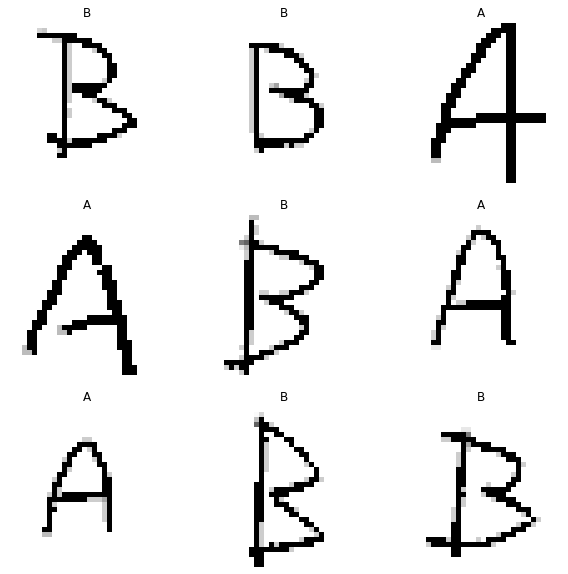

In [11]:
#Visualize data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

In [41]:
# There are some ways to improve the NN performance by making some changes to the dataset

#Here's one of them
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [38]:
#Test on a default model

#Build
model = tf.keras.Sequential()

model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1024, activation='sigmoid'))
model.add(tf.keras.layers.Dense(lenClasses, activation='softmax'))

#Compile
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

#Train
Nepochs = 5
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=Nepochs
)

#Test
results = model.evaluate(val_ds)
print(f"Results with {Nepochs} training epochs:")
print(f"Accuracy: {results[1]}")

Epoch 1/5
2/2 [==============================] - 1s 143ms/step - loss: 0.5524 - accuracy: 0.7000 - val_loss: 0.6444 - val_accuracy: 0.7000
Epoch 2/5
2/2 [==============================] - 0s 38ms/step - loss: 2.7105 - accuracy: 0.6500 - val_loss: 1.1317 - val_accuracy: 0.4000
Epoch 3/5
2/2 [==============================] - 0s 39ms/step - loss: 0.3956 - accuracy: 0.7500 - val_loss: 1.2093 - val_accuracy: 0.4000
Epoch 4/5
2/2 [==============================] - 0s 41ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0045 - val_accuracy: 0.4000
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 0.8822 - accuracy: 0.4000
Results with 5 training epochs:
Accuracy: 0.4000000059604645


In [51]:
#test with model built for this structure

#Build

model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(lenClasses)
])
model2.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy', f1_metric])

Nepochs = 10
model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=Nepochs
)

results = model2.evaluate(val_ds)
print(f"Results with {Nepochs} training epochs:")
print(f"Accuracy: {results[1]}")
print(f"F1-score: {results[2]}")

Epoch 1/10
2/2 [==============================] - 0s 120ms/step - loss: 0.7220 - accuracy: 0.4500 - f1_metric: 0.0000e+00 - val_loss: 0.7264 - val_accuracy: 0.4000 - val_f1_metric: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 0s 15ms/step - loss: 0.6556 - accuracy: 0.5500 - f1_metric: 0.0000e+00 - val_loss: 0.6956 - val_accuracy: 0.4000 - val_f1_metric: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 0s 14ms/step - loss: 0.6178 - accuracy: 0.5500 - f1_metric: 0.0000e+00 - val_loss: 0.6630 - val_accuracy: 0.5000 - val_f1_metric: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 0s 14ms/step - loss: 0.5851 - accuracy: 0.8500 - f1_metric: 0.0000e+00 - val_loss: 0.6293 - val_accuracy: 0.6000 - val_f1_metric: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 0s 13ms/step - loss: 0.5497 - accuracy: 1.0000 - f1_metric: 0.0000e+00 - val_loss: 0.6007 - val_accuracy: 0.7000 - val_f1_metric: 0.0000e+00
Epoch 6/10
2/2 [============================

In [66]:
#Build

model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(lenClasses)
])
model2.compile(
  optimizer='adam',
  #loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy', f1_metric])

Nepochs = 10
model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=Nepochs
)

results = model2.evaluate(val_ds)
print(f"Results with {Nepochs} training epochs:")
print(f"Accuracy: {results[1]}")
print(f"F1-score: {results[2]}")


Epoch 1/10
2/2 [==============================] - 1s 127ms/step - loss: 4.7246 - accuracy: 0.5500 - f1_metric: 0.2857 - val_loss: 3.5093 - val_accuracy: 0.4000 - val_f1_metric: 0.5714
Epoch 2/10
2/2 [==============================] - 0s 13ms/step - loss: 4.6037 - accuracy: 0.5500 - f1_metric: 0.6975 - val_loss: 3.4495 - val_accuracy: 0.4000 - val_f1_metric: 0.5714
Epoch 3/10
2/2 [==============================] - 0s 13ms/step - loss: 4.5335 - accuracy: 0.5500 - f1_metric: 0.6975 - val_loss: 3.3816 - val_accuracy: 0.4000 - val_f1_metric: 0.8889
Epoch 4/10
2/2 [==============================] - 0s 13ms/step - loss: 4.5234 - accuracy: 0.5500 - f1_metric: 0.9286 - val_loss: 3.3616 - val_accuracy: 0.4000 - val_f1_metric: 1.0000
Epoch 5/10
2/2 [==============================] - 0s 12ms/step - loss: 4.5124 - accuracy: 0.5500 - f1_metric: 0.9286 - val_loss: 3.3500 - val_accuracy: 0.4000 - val_f1_metric: 1.0000
Epoch 6/10
2/2 [==============================] - 0s 12ms/step - loss: 4.4845 - accu